In [18]:
# docker pull jupyter/datascience-notebook
# docker run -p 8888:8888 -v `pwd`:/home/jovyan/work -it jupyter/datascience-notebook

import math
from typing import Tuple, List, Callable
import scipy  # type: ignore
import scipy.integrate  # type: ignore
import matplotlib.pyplot as plt  # type: ignore

In [3]:
SUN_MASS = 1.989e30

# https://ru.wikipedia.org/wiki/%D0%9C%D0%B8%D1%80-%D0%9A%D0%BE%D0%BB%D1%8C%D1%86%D0%BE#%D0%9F%D0%B0%D1%80%D0%B0%D0%BC%D0%B5%D1%82%D1%80%D1%8B_%D0%9A%D0%BE%D0%BB%D1%8C%D1%86%D0%B0
RING_MASS = 2e27  # kg
RING_RADIUS = 1.53e11  # m
RING_WIDTH = 1.6e9  # m

INTEGRATION_TOP_STEPS = 720

G = 6.67e-11

SPLIT_RECT_REL_THRESHOLD = 0.1

Point = Tuple[float, float, float]
Rect = Tuple[Point, Point, Point, Point]

In [34]:
def avg(a: float, b: float) -> float:
    return (a+b)/2


def middle_point(p1: Point, p2: Point) -> Point:
    x1, y1, z1 = p1
    x2, y2, z2 = p2
    return avg(x1, x2), avg(y1, y2), avg(z1, z2)


def rect_center(rect: Rect) -> Point:
    p1, p2, p3, p4 = rect
    p12 = middle_point(p1, p2)
    p34 = middle_point(p3, p4)
    return middle_point(p12, p34)


def split_rect(rect: Rect) -> List[Rect]:  # splits 1 rect in 4
    p1, p2, p3, p4 = rect
    p12 = middle_point(p1, p2)
    p23 = middle_point(p2, p3)
    p34 = middle_point(p3, p4)
    p41 = middle_point(p4, p1)
    center = rect_center(rect)
    return [
        (p1, p12, center, p41),
        (p12, p2, p23, center),
        (p41, center, p34, p4),
        (center, p23, p3, p34),
    ]


def distance_square(p1: Point, p2: Point = (0, 0, 0)) -> float:
    x1, y1, z1 = p1
    x2, y2, z2 = p2
    return (x1-x2)**2 + (y1-y2)**2 + (z1-z2)**2


def distance(p1: Point, p2: Point = (0, 0, 0)) -> float:
    return math.sqrt(distance_square(p1, p2))


def sum_v(*vectors) -> Point:
    return tuple(map(sum, zip(*vectors)))  # type: ignore


def integrate_rect(rect: Rect, mass: float, point: Point) -> Point:
    points = list(rect) + [rect_center(rect)]
    distances = [distance(point, p) for p in points]
    max_distance = max(distances)
    min_distance = min(distances)
    if max_distance < 1:
        return 0, 0, 0  # point is inside ring so we stop recursion
    rel = (max_distance - min_distance) / min_distance
    if rel > SPLIT_RECT_REL_THRESHOLD:
        return sum_v(*[integrate_rect(rect2, mass/4, point) for rect2 in split_rect(rect)])
    else:
        center = rect_center(rect)
        length = G * mass / distance_square(center, point)
        dist = distance(point, center)
        k = length / dist
        x1, y1, z1 = center
        x2, y2, z2 = point
        return (x1-x2)*k,(y1-y2)*k,(z1-z2)*k


def integrate(point: Point) -> Point:
    degree_step = 360/INTEGRATION_TOP_STEPS
    acc = []
    for i in range(INTEGRATION_TOP_STEPS):
        degree = i * degree_step
        radians = math.radians(degree)
        radians2 = math.radians(degree + degree_step)
        z = RING_WIDTH / 2
        y1 = math.sin(radians) * RING_RADIUS
        x1 = math.cos(radians) * RING_RADIUS
        y2 = math.sin(radians2) * RING_RADIUS
        x2 = math.cos(radians2) * RING_RADIUS
        rect = (
            (y1, x1, +z),
            (y1, x1, -z),
            (y2, x2, -z),
            (y2, x2, +z),
        )
        acc.append(integrate_rect(rect, RING_MASS/INTEGRATION_TOP_STEPS, point))
    return sum_v(*acc)

def satellite_gv(height: float) -> Tuple[float, float]:
    assert height > 0  # otherwise fix code to account for ring gravitation direction
    r = RING_RADIUS - height
    sun_g = G * SUN_MASS / (r ** 2)
    ring_g_v = integrate((r, 0, 0))
    g = sun_g - distance(ring_g_v)
    satellite_v = math.sqrt(g * r)
    return g, satellite_v


def stability(height: float, dh: float = 1) -> bool:  # height relative to ring
    g, satellite_v = satellite_gv(height)
    g2, satellite_v2 = satellite_gv(height - dh)  # rise with positive dh, height above ring is lower
    #
    ped = (g+g2)/2*dh # potential energy differential
    ke = satellite_v**2 / 2 # kinetic energy
    ke2 = satellite_v2 ** 2 / 2
    result = ke < (ke2 + ped)
    #print(ke - (ke2 + ped))
    if dh < 0:
        result = not result
    return result

def find_boundary(h1, h2, dh = 1):
    h12 = avg(h1, h2)
    if abs(h2 - h1) < dh:
        return h12
    s1 = stability(h1)
    s12 = stability(h12)
    s2 = stability(h2)
    assert s1 != s2
    if s1 == s12:
        return find_boundary(h12, h2, dh)
    else:
        return find_boundary(h1, h12, dh)

def dg(height: float, dh: float = 1) -> float:
    assert height > 0  # otherwise fix code to account for ring gravitation direction
    r = RING_RADIUS - height
    sun_g = G * SUN_MASS / (r ** 2)
    ring_g = distance(integrate((r, 0, 0)))
    sun_g2 = G * SUN_MASS / ((r-dh) ** 2)
    ring_g2 = distance(integrate(((r-dh), 0, 0)))
    return (sun_g2 - ring_g2) - (sun_g - ring_g), sun_g2 - sun_g, ring_g2 - ring_g

def ring_side_potential(points=100, height = 1e6) -> float:
    r = RING_RADIUS - height
    acc = []
    for i in range(points):
        z = RING_WIDTH / 2 * i / (points - 1)
        ring_g = integrate((r, 0, z))
        _, _, az = ring_g
        acc.append((az, z))
    return scipy.integrate.simps(*zip(*acc))

def scalar(v1: Point, v2: Point) -> float:
    x1, y1, z1 = v1
    x2, y2, z2 = v2
    return x1*x2 + y1*y2 + z1*z2

def mul_v(v: Point, a: float) -> Point:
    x, y, z = v
    return a*x, a*y, a*z


def unit(v: Point) -> Point:
    d = distance(v)
    return mul_v(v, 1/d)


def rotate_z(p: Point, alpha_rad: float) -> Point:
    x, y, z = p
    cs = math.cos(alpha_rad)
    sn = math.sin(alpha_rad)
    x = x * cs + y * sn
    y = y * cs - x * sn
    return x, y, z


def leapfrog(time: float, p: Point, v: Point, fa: Callable[[Point], Point], dt: float = 1e4) -> List[Point]:
    points = []
    # https://en.wikipedia.org/wiki/Leapfrog_integration
    points.append(p)
    t = 0.
    a_prev = fa(p)
    while t <= time:
        vdt = mul_v(v, dt)
        p1 = sum_v(p, vdt, mul_v(a_prev, (dt**2) / 2))
        a_cur = fa(p1)
        v1 = sum_v(v, mul_v(sum_v(a_prev, a_cur), dt / 2))
        # rotate vectors to keep y close to 0
        for i in range(0):  #TODO ? 1 or 2
            d = distance(p1)
            alpha = p1[1] / d
            p1 = rotate_z(p1, alpha)
            v1 = rotate_z(v1, alpha)
            a_cur = rotate_z(a_cur, alpha)
        #assert abs(p1[1]) < 1
        # save
        points.append(p1)
        v = v1
        p = p1
        a_prev = a_cur
        t += dt
    return points


def ring_a(p: Point) -> Point:
    ring_g_v = integrate(p)
    sun_g = G * SUN_MASS / distance_square(p)
    sun_g_v = mul_v(unit(p), -sun_g)
    a = sum_v(ring_g_v, sun_g_v)
    return a


def run_ring(time: float, height: float, z: float, dt: float = 1e4):
    #TODO use satellite_gv()?
    r = RING_RADIUS - height
    vector = (r, 0, z)
    ring_g_v = integrate(vector)
    ring_g = scalar(unit(vector), ring_g_v)
    sun_g = G * SUN_MASS / distance_square(vector)
    g = sun_g - ring_g
    satellite_v = math.sqrt(g * distance(vector))
    v = (0., satellite_v, 0.)
    p = (r, 0., z)
    return leapfrog(time, p, v, ring_a, dt)


def draw_orbit(points: List[Point]) -> None:
    _, _, zs = zip(*points)
    xs = [RING_RADIUS - distance(p) for p in points]
    plt.scatter(zs, xs)
    plt.plot(zs, xs)
    # ring line
    rz, rx = (-RING_WIDTH/2, +RING_WIDTH/2), (0, 0)
    plt.scatter(rz, rx)
    plt.plot(rz, rx)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()
    

In [5]:
# test integrate()
print(integrate((0,0,0)))
print(integrate((RING_RADIUS - 1,0,0)))
print(integrate((RING_RADIUS + 1,0,0)))
print(integrate((RING_RADIUS - 1e3,0,0)))
print(integrate((RING_RADIUS - 1e6,0,0)))
print(integrate((RING_RADIUS - 1e9,0,0)))
print(integrate((RING_RADIUS,0,0)))

(8.969739767371894e-24, -6.28657265540301e-23, 0.0)
(0.0005096442376344563, -1.2427893841607542e-11, -2.1564929441502453e-19)
(-0.0005801376446593025, 1.5847479181097444e-11, 1.733770563911146e-21)
(0.0005201188861631926, -1.2231437433203006e-14, 1.7205356741102976e-22)
(0.0005301388183980967, 1.7078459376921522e-17, -1.0863197548536402e-19)
(0.00022980742807548256, 3.8956649974613625e-19, 1.707300784309449e-21)
(-3.727911871724076e-05, -1.2281638758735157e-08, 6.507860012873196e-19)


In [6]:
print(satellite_gv(1e6))
print(satellite_gv(1e6+1e3))

print(stability(1e6))
print('---')
print(stability(1e7/3))
print(stability(1e9))
print('---')
print(stability(3e9))

(0.005137255526383915, 28035.601621531372)
(0.005137255258460756, 28035.60079884114)
-0.02816873788833618
True
---
0.019803285598754883
False
0.010334968566894531
False
---
-0.0005118250846862793
True


In [10]:
# region of instability - between 2,207 km and 2,63 Mkm
print('boundary')
print(find_boundary(1e6, 1e7/3))
print(find_boundary(1e9, 3e9))

boundary
2206939.3396377563
2629883170.5935297


In [36]:
# stability near ringworld is due sign change of ring dg
print(dg(1e6))
print(dg(1e7/3))
print(dg(1e7))
print(dg(1e10))

(-2.674891558251957e-13, 7.408396812680351e-14, 3.415732323722165e-13)
(3.595934314204463e-13, 7.408830493549345e-14, -2.8550512648495285e-13)
(5.096843086471736e-13, 7.409784591461133e-14, -4.3558700483364854e-13)
(9.343914531001474e-14, 9.073731349618086e-14, -2.702221448989614e-15)


In [20]:
print('ring_side_potential:')  # so ring edge gravity potential is about 200 KJ
print(ring_side_potential(points=10))
print(ring_side_potential(points=30))
print(ring_side_potential(points=100))

ring_side_potential:
-206998.19407977755
-194531.82547191874
-192228.1044553615


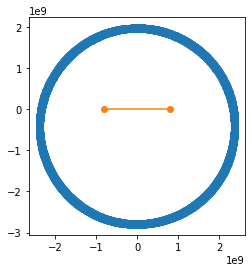

In [14]:
height = 2e9
r = RING_RADIUS - height
p = (r, 0, 0)
satellite_v = math.sqrt(distance(ring_a(p)) * distance(p))
a_ring = distance(integrate(p))
satellite_v2 = math.sqrt(a_ring * height)
v = (0, satellite_v*1.02, satellite_v2*1.45)
points3 = leapfrog(1e8, p, v, ring_a, dt=2e4)
draw_orbit(points3)

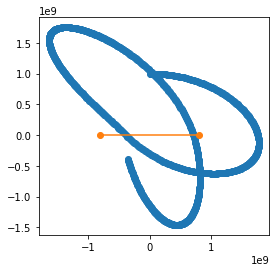

In [21]:
height = 1e9
r = RING_RADIUS - height
p = (r, 0, 0)
satellite_v = math.sqrt(distance(ring_a(p)) * distance(p))
a_ring = distance(integrate(p))
satellite_v2 = math.sqrt(a_ring * height)
v = (0, satellite_v*1.02, satellite_v2*1.55)
points3 = leapfrog(1e8/4, p, v, ring_a, dt=2e4)
draw_orbit(points3)

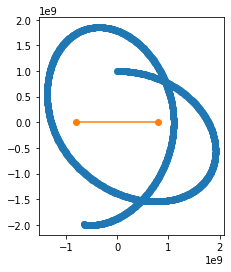

In [22]:
height = 1e9
r = RING_RADIUS - height
p = (r, 0, 0)
satellite_v = math.sqrt(distance(ring_a(p)) * distance(p))
a_ring = distance(integrate(p))
satellite_v2 = math.sqrt(a_ring * height)
v = (0, satellite_v*1.025, satellite_v2*1.65)
points3 = leapfrog(1e8/4, p, v, ring_a, dt=2e4)
draw_orbit(points3)

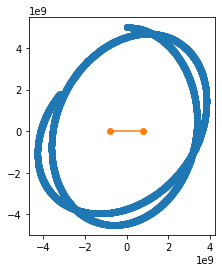

In [37]:
height = 5e9
r = RING_RADIUS - height
p = (r, 0, 0)
satellite_v = math.sqrt(distance(ring_a(p)) * distance(p))
a_ring = distance(integrate(p))
satellite_v2 = math.sqrt(a_ring * height)
v = (0, satellite_v*1.02, satellite_v2*1.55)
points3 = leapfrog(1e8/2, p, v, ring_a, dt=2e4)
draw_orbit(points3)

In [27]:
EARTH_MASS = 5.972e24
EARTH_RADIUS = 6.378e6

In [30]:
def earth_a(p: Point) -> Point:
    earth_g = G * EARTH_MASS / distance_square(p)
    earth_g_v = mul_v(unit(p), -earth_g)
    return earth_g_v

def draw_earth_orbit(points: List[Point]) -> None:
    xs, ys, _ = zip(*points)
    plt.scatter(xs, ys)
    plt.plot(xs, ys)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

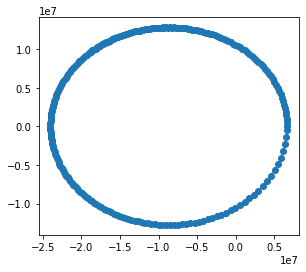

In [31]:
r = EARTH_RADIUS + 3e5
p = (r, 0, 1e6)
satellite_v = math.sqrt(distance(earth_a(p)) * distance(p))
v = (0, satellite_v*1.25, 0)

points = leapfrog(24.9e3, p, v, earth_a, 1e2)
draw_earth_orbit(points)